# Macroeconomic forecasting: Can machine learning methods outperform traditional approaches?

## 0. Setup of the notebook


### Loading packages and modules

In [1]:
import os
import numpy as np
import pandas as pd

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, TensorDataset

import torch as T
import torch.nn as nn
import torch.nn.functional as F

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import pickle

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 1. Data

## 1.1 Real gross domestic product 

The gross domestic product (GDP) is the variable of interest.

Source of the data public availabe on the website of the IMF [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October/download-entire-database) and provided via an Excel file called `WEOApr2020all.xls`.

In [2]:
file = r"C:\Users\hauer\Dropbox\CFDS\Project\data\WEOApr2020all.csv"
df_weo_real_gdp = pd.read_csv(file)

There are several types of data in this file. This is the description of the relevant subject, the growth of the GDP:

In [3]:
idx = df_weo_real_gdp['Subject Descriptor'] == 'Gross domestic product, constant prices'
df_weo_real_gdp['Subject Notes'] 

df_weo_real_gdp.loc[idx, 'Subject Notes'].unique()

array(['Annual percentages of constant price GDP are year-on-year changes; the base year is country-specific . Expenditure-based GDP is total final expenditures at purchasers? prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]'],
      dtype=object)

In [4]:
df_weo_real_gdp.loc[idx, 'Units'].unique()

array(['Percent change'], dtype=object)

The subject code given by the IMF is 'NGDP_RPCH'. This code will also occour in for the weo prediction data. 

In [5]:
df_weo_real_gdp.loc[idx, 'WEO Subject Code'].unique()

array(['NGDP_RPCH'], dtype=object)

As the data for the years are present in the columns of the dataframe, i exctract the relevant information and transpose it afterwars. I want the years as the rows and the variables as the columns. 

In [6]:
df_weo_real_gdp.columns

Index(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', 'Estimates Start After'],
      dtype='object')

This is done with the function: 

In [7]:
def get_imf_woe_data(df_weo_real_gdp, country, remove_na=False):

    df = df_weo_real_gdp[df_weo_real_gdp['Country'] == country]
    
    result = pd.DataFrame()
    
    available_variables = df['Subject Descriptor'].unique()
    
    for variable in available_variables:
        df_curr = df[df['Subject Descriptor'] == variable]
        df_curr = df_curr.iloc[:, 9:49]
        df_curr = df_curr.transpose()
        df_curr = df_curr.rename({df_curr.columns[0]: variable}, axis='columns')
        result = pd.concat([result, df_curr], axis=1)
        
        
    if remove_na:
        result = result.dropna(axis=1) 
        
    return result

To extract the GDP data i use this function: 

In [8]:
def get_gdp_real(df_weo_real_gdp, country):
    df = get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
    df.index = df.index.astype(dtype='int64')   
    df['GDP real'] = df['Gross domestic product, constant prices']  
    df['GDP real'] = df['GDP real'].str.replace(',', '').astype('float')
    return df['GDP real']

Here is for example the real GDP growth for germany:

In [9]:
get_gdp_real(df_weo_real_gdp, 'Germany')

1980    1.272
1981    0.110
1982   -0.788
1983    1.555
1984    2.826
1985    2.192
1986    2.417
1987    1.469
1988    3.736
1989    3.913
1990    5.723
1991    5.011
1992    1.925
1993   -0.976
1994    2.395
1995    1.541
1996    0.814
1997    1.790
1998    2.019
1999    1.885
2000    2.905
2001    1.689
2002   -0.201
2003   -0.708
2004    1.186
2005    0.728
2006    3.815
2007    2.975
2008    0.965
2009   -5.694
2010    4.185
2011    3.913
2012    0.428
2013    0.431
2014    2.218
2015    1.742
2016    2.230
2017    2.465
2018    1.522
2019    0.565
Name: GDP real, dtype: float64

The real GDP is availabe for the following 194 (one occurrence is Nan) countries: 

In [10]:
countries_woe_real = df_weo_real_gdp['Country'].unique()
len(countries_woe_real)

195

In [11]:
countries_woe_real

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Gui

## 1.2 The variables X

### 1.2.1 IMF

The IMF proivdes some economic variables along with the realised GDP, that are already in the `df_weo_real_gdp` dataframe:

In [12]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data.head()

,"Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product per capita, constant prices","Inflation, average consumer prices","Inflation, end of period consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,1.272,867.363,0.931,5.447,NaN,3.359,NaN,-1.782
1981,0.11,950.471,-0.078,6.324,NaN,4.831,NaN,-0.684
1982,-0.788,"1,001.24",-0.717,5.256,NaN,6.734,NaN,0.866
1983,1.555,"1,056.63",1.91,3.284,NaN,8.099,NaN,0.666
1984,2.826,"1,125.70",3.243,2.396,NaN,8.058,NaN,1.423


I will use the following quantities:

In [13]:
imf_woe_variables = ['Inflation, average consumer prices', 'Unemployment rate', 'General government net lending/borrowing', 'Current account balance']

for x in imf_woe_variables:
    idx = df_weo_real_gdp['Subject Descriptor'] == x
    print(x)
    print(df_weo_real_gdp.loc[idx, 'Subject Notes'].unique())
    print(df_weo_real_gdp.loc[idx, 'Units'].unique())
    print('')

Inflation, average consumer prices
['Annual percentages of average consumer prices are year-on-year changes.']
['Percent change']

Unemployment rate
['Unemployment rate can be defined by either the national definition, the ILO harmonized definition, or the OECD harmonized definition. The OECD harmonized unemployment rate gives the number of unemployed persons as a percentage of the labor force (the total number of people employed plus unemployed). [OECD Main Economic Indicators, OECD, monthly] As defined by the International Labour Organization, unemployed workers are those who are currently not working but are willing and able to work for pay, currently available to work, and have actively searched for work. [ILO, http://www.ilo.org/public/english/bureau/stat/res/index.htm]']
['Percent of total labor force']

General government net lending/borrowing
['Net lending (+)/ borrowing (?) is calculated as revenue minus total expenditure. This is a core GFS balance that measures the extent to

So only `Inflation, average consumer prices` is given by an annual percentage change, the other variables needs to be transformed later. 

The dataframe for example for germany will look like this:

In [14]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data[imf_woe_variables]

,"Inflation, average consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,5.447,3.359,NaN,-1.782
1981,6.324,4.831,NaN,-0.684
1982,5.256,6.734,NaN,0.866
1983,3.284,8.099,NaN,0.666
1984,2.396,8.058,NaN,1.423
1985,2.084,8.124,NaN,2.662
1986,-0.125,7.834,NaN,4.024
1987,0.242,7.843,NaN,3.709
1988,1.274,7.735,NaN,4.317
1989,2.778,6.79,NaN,4.689


### 1.2.3 OECD

The Organisation for Economic Co-operation and Development (OECD) provied also macroeconomic data in its [iLibrary]( https://www.oecd-ilibrary.org). The indicators can be browsed by theme and I choose 19 to use for my forecast. Each one is available by an `.csv` file. I load all of them together into one dataframe: 

In [15]:
def get_oecd_data(path_oecd, country): 
 
    result = pd.DataFrame()
  
    
    for file_name in os.listdir(path_oecd):
    
        
        file = os.path.join(path_oecd, file_name)
        
        df_orig = pd.read_csv(file)
        unique_subjects = df_orig['SUBJECT'].unique()
    
        
        for subject in unique_subjects:
            
            
            df = df_orig.copy()
            df = df[df['LOCATION'] == country] 
            df = df[df['SUBJECT'] == subject]
            
            # if there is only one unique subject, the name is TOT
            if(len(unique_subjects) == 1):
                subject = file_name[:-4]
            
            
            df = df.rename({df.columns[6]: subject}, axis='columns')
            
            df = df.set_index('TIME')
            
            result = pd.concat([result, df[subject]], axis=1)           
    
    return result

In [16]:
path_oecd = r'C:\Users\hauer\Dropbox\CFDS\Project\data\OECD'

df_oecd = get_oecd_data(path_oecd, 'USA')
df_oecd.tail()

,Air_Pollution,BuiltArea,RICE,WHEAT,MAIZE,SOYBEAN,CurrentAccountBalance,ExchangeR,GHG,Gini,...,POULTRY,SHEEP,PPP,ProtectedArea,STINT,TermsOfTrade,TradeGoodsExport,TradeGoodsImport,TradeServicesExport,TradeServicesImports
2016,7.37633,NaN,5.639440,3.545315,10.966925,3.493525,-2.109880,1.0,14.9,0.391,...,48.546693,0.452834,1.0,12.54,0.644167,101.649388,1451.022,2187.599,780531.0,511898.0
2017,7.36365,NaN,5.865637,3.112192,11.084471,3.314508,-1.871310,1.0,14.6,0.390,...,48.995385,0.486937,1.0,12.54,1.152500,101.989233,1546.472,2339.885,830387.0,544836.0
2018,NaN,NaN,5.989749,3.199564,11.078778,3.503500,-2.185078,1.0,NaN,NaN,...,49.682862,0.468909,1.0,12.54,2.188333,102.492082,1665.688,2537.730,862434.0,562069.0
2019,NaN,NaN,5.903469,3.214364,11.146953,3.297754,-2.241142,1.0,NaN,NaN,...,50.071359,0.448355,1.0,12.54,NaN,NaN,1643.161,2497.532,875825.0,588359.0
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.54,NaN,NaN,NaN,NaN,NaN,NaN


All of the variables are given absolute values for the specific year, so every variable needs to be transformed afterwards.
There are 182 countries or aggregated country groups available:

In [17]:
countries_oecd = set()

for file_name in os.listdir(path_oecd):
    file = os.path.join(path_oecd, file_name)
    df = pd.read_csv(file)
    countries_current = set(df['LOCATION'].unique())
    
    countries_oecd = countries_oecd.union(countries_current)

    
countries_oecd = list(countries_oecd)
len(countries_oecd)

182

In [18]:
countries_oecd

['POL',
 'HUN',
 'ITA',
 'MAC',
 'SWE',
 'LUX',
 'NZL',
 'PNG',
 'MUS',
 'JPN',
 'LBN',
 'MAR',
 'MRT',
 'EST',
 'NLD',
 'EU27',
 'TUN',
 'SGP',
 'YEM',
 'HND',
 'ISL',
 'BGR',
 'CMR',
 'UKR',
 'LTU',
 'BIH',
 'USA',
 'SOM',
 'ZWE',
 'TGO',
 'PER',
 'DOM',
 'GEO',
 'GHA',
 'G-20',
 'BWA',
 'ALB',
 'BRN',
 'BDI',
 'CYP',
 'GNQ',
 'BRICS',
 'PAN',
 'AZE',
 'TZA',
 'GNB',
 'TCD',
 'QAT',
 'IND',
 'PRY',
 'HKG',
 'GMB',
 'AUT',
 'VNM',
 'AUS',
 'RWA',
 'MMR',
 'ECU',
 'COL',
 'MDG',
 'SLV',
 'EA',
 'VEN',
 'CHN',
 'ARG',
 'DEW',
 'SDN',
 'AGO',
 'ESP',
 'PRK',
 'EGY',
 'ARE',
 'ZMB',
 'HRV',
 'BTN',
 'NPL',
 'OEU',
 'ZAF',
 'UZB',
 'GTM',
 'BHR',
 'BLR',
 'COG',
 'SWZ',
 'G-7',
 'UGA',
 'IRN',
 'BRA',
 'TJK',
 'PHL',
 'SEN',
 'OAVG',
 'HTI',
 'SAU',
 'CHL',
 'DNK',
 'IDN',
 'CAF',
 'JAM',
 'GBR',
 'LIE',
 'G20',
 'OECD',
 'IRL',
 'NOR',
 'LSO',
 'SVN',
 'JOR',
 'FJI',
 'KHM',
 'MOZ',
 'LAO',
 'KEN',
 'NAM',
 'CHE',
 'KGZ',
 'CUB',
 'KWT',
 'LVA',
 'SVK',
 'EU',
 'EU28',
 'WLD',
 'OECDE',
 

Here is the mapping from the ISO country code that used the OECD to the country names that are used by the IMF:

In [19]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data\Mapping_country_codes.csv'
df_country_mapping =  pd.read_csv(path, sep = '\t')

df_country_mapping

,ID,ISO,Country
0,1,AFG,Afghanistan
1,2,ALB,Albania
2,3,DZA,Algeria
3,4,AGO,Angola
4,5,ATG,Antigua and Barbuda
...,...,...,...
190,191,VNM,Vietnam
191,192,YEM,Yemen
192,193,ZMB,Zambia
193,194,ZWE,Zimbabwe


## 1.3  World Economic Outlook 


The International Monetary Fund publishes predictions of the GDP growth in its World Economic Outlook. The data can is taken from [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October) in the related links Historical WEO Forecasts Database. The data is provided in an Excel file called `WEOhistorical.xlsx`. The IMF publishes the WEO twice a year in spring and in fall. I will use the prediction of the fall, as this closer to the next year and therefore the prediction should be more precise. The data is formated the following: 

| country | year   |F1990ngdp_rpch|
|------|--------|--------------|
|   germany  | 1988  | 4.08 |
|   germany  | 1989  | 2.96 |
|   germany  | 1990  | 1.98 |
|   germany  | 1991  | 2.44 |
|   germany  | 1992  | 3.42 |
|   germany  | 1993  | 3.45 |
|   germany  | 1994  | 3.42 |
|   germany  | 1995  | 3.40 |

This is for example the WEO in fall of 1990 for germany. There are two years of historical data and 6 years of forecast data. The forecast can be found in the column `F1990ngdp_rpch`. This is the same subject code as for the realised GDP. I will only use the forecast for the next year, so for 1990 if will use the predicted growth of the GDP in 1991. I extract the forecast for a certain country and prediciton horizon with the following function. First I load the Excel file into an pandas dataframe:

In [20]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data\WEOhistorical.xlsx'
df_weo =  pd.read_excel(path,sheet_name='ngdp_rpch')

The function for the extraction of the WEO is called `get_predictions_weo`:

In [21]:
def get_predictions_weo(df_weo, country, start_forecast, end_forecast):
       
    df = df_weo[df_weo['country'] == country]
    
    
    for col in df.columns:
        if 'S' in col:
            del df[col] 
            
    del df['WEO_Country_Code']     
    
    
    df = df[df['year'] >= start_forecast]
    
    
    predictions_weo = []
    years = np.arange(start_forecast, end_forecast+1, 1)
    
    for year in years:
       
        df_curr = df[df['year'] == year]
        
        year_WEO = year - 1 
        column = 'F' + str(year_WEO) + 'ngdp_rpch'
        y_pred_year = df_curr[column].values[0]
        
        predictions_weo.append(y_pred_year)
    
    predictions_weo = pd.Series(data = predictions_weo, index = years)
    
    return predictions_weo

Here is for example the WEO for germany for the years 2010 to 2018:


In [22]:
get_predictions_weo(df_weo, country = 'Germany', start_forecast =  2010, end_forecast = 2018)

2010    0.335834
2011    2.021567
2012    1.273123
2013    0.852179
2014    1.399657
2015    1.451330
2016    1.573023
2017    1.425094
2018    1.843451
dtype: float64

The WEO is available from 1980 for the following countries or aggregated country groups:

In [23]:
countries_woe = df_weo['country'].unique()
len(countries_woe)

199

In [24]:
countries_woe

array(['World', 'Advanced Economies', 'United States', 'United Kingdom',
       'Austria', 'Belgium', 'Denmark', 'France', 'Germany', 'San Marino',
       'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Sweden',
       'Switzerland', 'Canada', 'Japan', 'Euro area', 'Finland', 'Greece',
       'Iceland', 'Ireland', 'Malta', 'Portugal', 'Spain', 'Turkey',
       'Australia', 'New Zealand', 'South Africa',
       'Emerging Market and Developing Economies', 'Argentina', 'Bolivia',
       'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras',
       'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay',
       'Venezuela', 'Antigua and Barbuda', 'Bahamas, The', 'Aruba',
       'Barbados', 'Dominica', 'Grenada', 'Guyana', 'Belize', 'Jamaica',
       'Puerto Rico', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Suriname',
       'Trinidad and Tobago', 'Bahrain', 'Cyprus', 'I

# 1.3 Joinig the datasets


Here I join the different data sets to get a dataframe for each country. The data is available from 1980 to 2019 expect for the OECD data sets. These are provided from 1970 to 2017 and hence I filter them to receive the time from 1980 to 2017. I use the pythonic try except block to select only countries, that have an correspondent ISO code in the OECD dataset.
I will save each individual dataframe in a dictionary. For later convenience I also rename the column of the real gdp.

In [25]:
database = {}

availabe_countries_woe = set(countries_woe_real).union(countries_woe)

for country in availabe_countries_woe:
    try:
        iso = df_country_mapping[df_country_mapping['Country'] == country]['ISO']
        iso = iso.values[0]
        
        df_real_gdp = get_gdp_real(df_weo_real_gdp, country)
        df_real_gdp = df_real_gdp[df_real_gdp.index <= 2017]
        
        df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
        df_imf_woe_data = df_imf_woe_data[imf_woe_variables]
        df_imf_woe_data.index = df_imf_woe_data.index.astype(int)
        df_imf_woe_data = df_imf_woe_data[df_imf_woe_data.index <= 2017]
        
        df_oecd = get_oecd_data(path_oecd, iso)
        df_oecd = df_oecd[df_oecd.index >= 1980]
        df_oecd = df_oecd[df_oecd.index <= 2017]
        
        
        df = pd.concat([df_real_gdp, df_imf_woe_data, df_oecd], axis=1)
        
        df = df.rename(columns={"GDP real": "y"})
        
        database[country] = df

    except Exception as e:
        print('Error' + str(e) + ' for ' + str(country))

Errorindex 0 is out of bounds for axis 0 with size 0 for nan
Errorindex 0 is out of bounds for axis 0 with size 0 for Iran
Errorcould not convert string to float: '--' for Gabon
Errorindex 0 is out of bounds for axis 0 with size 0 for Gambia, The
Errorindex 0 is out of bounds for axis 0 with size 0 for West Bank and Gaza
Errorcould not convert string to float: '--' for Mauritania
Errorindex 0 is out of bounds for axis 0 with size 0 for Emerging Market and Developing Economies
Errorcould not convert string to float: '--' for Angola
Errorindex 0 is out of bounds for axis 0 with size 0 for Montenegro, Rep. of
Errorindex 0 is out of bounds for axis 0 with size 0 for Advanced Economies
Errorindex 0 is out of bounds for axis 0 with size 0 for Euro area
Errorindex 0 is out of bounds for axis 0 with size 0 for Congo, Republic of
Errorcould not convert string to float: '--' for Greece
Errorindex 0 is out of bounds for axis 0 with size 0 for Bahamas, The
Errorindex 0 is out of bounds for axis 0 

Now I have 189 dataframes that are ready to be analysed: 

In [26]:
len(database.keys())

189

## Fixing data type

During the later analysis there occured problems with wrong datatypes. For example some vaules where saved as strings: `unsupported operand type(s) for /: 'str' and 'str'`. In this section I fix all kind of this problems. 

Here is a list of the issues which i fix in the same order in the following code: 
* Netherlands could not convert string to float: '--'
* Brazil could not convert string to float: '1,430.72'
* Hungary unsupported operand type(s) for /: 'str' and 'str'


In [27]:
def convert_string_series(x):
    try:
        return x.str.replace(',', '').astype(float)
    
    # this operation only works with string vaules, i was not able to filter the other dtypes
    # (that should only be float) but it did not work. 
    
    except:
        return x


database_fixed = {}


for country in database.keys():
    try: 
        # Netherlands could not convert string to float: '--'
        database_fixed[country] =  database[country].replace('--', np.nan)

        # Brazil could not convert string to float: '1,430.72'
        database_fixed[country] =  database[country].replace(',', '')

        # Hungary unsupported operand type(s) for /: 'str' and 'str'
        database_fixed[country]  = database[country].apply(convert_string_series)
        
       
    except Exception as e:
        print(country + " " + str(e))


database = database_fixed.copy()

## Filitering missing values

First I define variables that i need later on. I will describe them before I use them:

In [28]:
t_missing_percentage = 0.6
number_of_qualified_variables = 15

Next i want to analyse how many values are missing. So I can decide which of the variables I will use for the models. To get an overview I count the number of missing values for all variables of all countries. To do this, I create a dictionary with all varibales available as keys.

In [29]:
variables = database['France'].columns
missing_dict = {var:0 for var in variables}

In [30]:
number_of_observations = 0
for country in database.keys():
    df =  database[country]   
    number_of_observations += df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations   

In [31]:
df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
df_missing.columns = ['Number of missing entries']
df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
df_missing.sort_values(by='Percent of missing entries', ascending=1)

,Number of missing entries,Percent of missing entries
y,794,11.055416
"Inflation, average consumer prices",819,11.403509
Current account balance,1105,15.385686
General government net lending/borrowing,2309,32.149819
GHG,2517,35.045948
Unemployment rate,3764,52.408800
ExchangeR,5148,71.679198
PPP,5314,73.990532
Air_Pollution,5322,74.101921
TradeGoodsExport,5698,79.337232


Here is the same analysis for a single country.

In [32]:
country = 'France'

def get_overview_missing_values(country):
    variables = database[country].columns
    missing_dict = {var:0 for var in variables}


    df =  database[country]   
    number_of_observations = df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations 

    df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
    df_missing.columns = ['Number of missing entries']
    df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
    df_missing = df_missing.sort_values(by='Percent of missing entries', ascending=1)
    
    return df_missing

df_missing = get_overview_missing_values(country) 
df_missing

,Number of missing entries,Percent of missing entries
y,0,0.000000
TradeGoodsImport,0,0.000000
TradeGoodsExport,0,0.000000
TermsOfTrade,0,0.000000
STINT,0,0.000000
PPP,0,0.000000
LTINT,0,0.000000
MFG,0,0.000000
GHG,0,0.000000
ExchangeR,0,0.000000


I want set a trheshold, when to not use a variable, because of too much missing data. A threshold `t_missing_percentage` means that every variable with more then 30% missing data will not qualify to be included for the next steps.

In [33]:
df_filtered = df_missing[df_missing['Percent of missing entries'] <= t_missing_percentage * 100]
df_filtered

,Number of missing entries,Percent of missing entries
y,0,0.000000
TradeGoodsImport,0,0.000000
TradeGoodsExport,0,0.000000
TermsOfTrade,0,0.000000
STINT,0,0.000000
PPP,0,0.000000
LTINT,0,0.000000
MFG,0,0.000000
GHG,0,0.000000
ExchangeR,0,0.000000


In [34]:
number_of_variables_filtered_na = df_filtered.shape[0]
number_of_variables_filtered_na

19

The dataframe of France has 16 variables that would qualify. Now I will see this number for all countries:

In [35]:
missing_dict = {var:0 for var in database.keys()}
number_of_variables = len(database['France'].columns)

for country in database.keys():

    df_missing = get_overview_missing_values(country) 
    df_filtered = df_missing[df_missing['Percent of missing entries'] <= t_missing_percentage * 100]
    number_of_variables_filtered_na = df_filtered.shape[0]
    
    missing_dict[country] = number_of_variables_filtered_na 
    
df_qualified_var_by_country = pd.DataFrame.from_dict(missing_dict, orient='index')
df_qualified_var_by_country.columns = ['number of qualified variables']
df_qualified_var_by_country['percent of qualified variables'] = df_qualified_var_by_country['number of qualified variables'] / number_of_variables * 100
df_qualified_var_by_country = df_qualified_var_by_country.sort_values(by='percent of qualified variables', ascending=0)
df_qualified_var_by_country

,number of qualified variables,percent of qualified variables
Australia,27,87.096774
Canada,27,87.096774
Korea,27,87.096774
United States,27,87.096774
Israel,26,83.870968
...,...,...
San Marino,2,6.451613
Afghanistan,2,6.451613
Nauru,0,0.000000
South Sudan,0,0.000000


Now I select only those countries, that have at least 15 qualifed variables. I use the variable `number_of_qualified_variables`:

In [36]:
df_selected_countries =df_qualified_var_by_country[df_qualified_var_by_country['number of qualified variables'] >= number_of_qualified_variables]
selected_countries = df_selected_countries.index
df_selected_countries

,number of qualified variables,percent of qualified variables
Australia,27,87.096774
Canada,27,87.096774
Korea,27,87.096774
United States,27,87.096774
Israel,26,83.870968
South Africa,26,83.870968
Japan,26,83.870968
Switzerland,26,83.870968
United Kingdom,25,80.645161
New Zealand,25,80.645161


Now I compute the intersection of those variables to ensure that the qualifed variables are the same. 

In [37]:
final_variables = set(database['France'].columns)

for country in selected_countries:

    df_curr = get_overview_missing_values(country)   
    df_curr = df_curr[df_curr['Percent of missing entries'] <= t_missing_percentage * 100]
    final_variables = final_variables.intersection(set(df_curr.index))

final_variables = list(final_variables)

Now I can filter the whole database so that only countries with the selected variables are available.

In [38]:
database_clear_na = {}

for country in database.keys():
    
    if country not in selected_countries:
        continue
        
    df_curr = database[country]
    df_curr = df_curr[final_variables]
   
    database_clear_na[country] = df_curr

The result is:

In [39]:
selected_countries

Index(['Australia', 'Canada', 'Korea', 'United States', 'Israel',
       'South Africa', 'Japan', 'Switzerland', 'United Kingdom', 'New Zealand',
       'Mexico', 'Russia', 'Turkey', 'Norway', 'Brazil', 'Colombia', 'Chile',
       'China', 'India', 'Indonesia', 'Finland', 'Italy', 'Germany',
       'Portugal', 'Hungary', 'Austria', 'Iceland', 'Czech Republic', 'Spain',
       'Ireland', 'France', 'Luxembourg', 'Sweden', 'Belgium', 'Argentina',
       'Saudi Arabia', 'Latvia', 'Estonia', 'Slovenia', 'Lithuania',
       'Netherlands', 'Costa Rica', 'Poland', 'Denmark', 'Slovak Republic',
       'Peru'],
      dtype='object')

In [40]:
final_variables

['GHG',
 'y',
 'PPP',
 'ExchangeR',
 'General government net lending/borrowing',
 'Current account balance',
 'Inflation, average consumer prices']

# Spliting the dataset

The reference for this section is the book "The Elements of Statistical Learning" from Hastie et. al. 

To obtain an accurate Data Science process, it is necessary to split the whole dataset in certain subsets.  This is important for two reasons:

* Model selection: estimating the performance of different models in order to choose the best one. The term model selection also includes the tuning of the hyperparameters, if you define a model as the tupel consisting of the data used for training, the concrete typ of model or algorithm and the hyperparameters of the later. 
* Model assessment: having chosen a final model, estimating its prediction error (generalization error) on new data.

The data is split into a training, validation and test set. The training set is used to fit the model and the validation set is used to calculate the validation error. This error gives an estimate of its prediction error. The test is kept in an "vault" and is brought out only at the very end of the analysis. After using the test set, no changes in any step is allowed. Otherwise the test error will underestimate the true test error. With this test error the selection of the best model is done. 

Another thing in this procedure is very important: Every step in the analysis needs to be performed on the training set only. For example in the next section I will impute missing values. I will fit the algorithim that performes the imputation on the training set and predict the values then for both the training and test set. Otherwise the wrong applicaton of the impuation would also underestimate the validation or test error, because for the imputation there would be more information available than in an real life scenario. New data is completly unseen and only the training data is available for fitting the model in generall. 

This is also noted in the section 7.10.2 The Wrong and Right Way to Do Cross-validation. Even though I am not doing cross validation, this description suits the application in this project. 


I will use the years 2014 - 2017 as the test set. I will calculate  the performance on the very end and after i will not change anythin in the procedure. The years  2010 - 2013 will be the validation set and will be use for tuning the hypterparameter. 

In [41]:
def split_dataset(database):
    database_training = {}
    database_validation = {}
    database_test = {}


    for country in database.keys():


        df = database[country]

        #df_test = df[df.index > 2013]
        #df_validation = df[(df.index > 2009) & (df.index <= 2013)]
        #df_training = df[df.index <= 2009]
        
#         df_test = df[df.index > 2012]
#         df_validation = df[(df.index > 2008) & (df.index <= 2012)]
#         df_training = df[df.index <= 2008]
        
        df_test = df[df.index > 2010]
        df_validation = df[(df.index > 2004) & (df.index <= 2010)]
        df_training = df[df.index <= 2004]

        database_training[country] = df_training
        database_validation[country] = df_validation
        database_test[country] = df_test
        
    return (database_training, database_validation, database_test)


database_training, database_validation, database_test = split_dataset(database_clear_na)

## Impute missing values

### Mean

In [42]:
from sklearn.impute import SimpleImputer

d = {'col1': [np.nan, 2, 2, 3, 4, 1, np.nan, 2, 1, 5], 'col2': [np.nan, np.nan, 3, 2, 1, 99, np.nan, 9999, 34, 56]}

In [43]:
df = pd.DataFrame(data=d)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,col1,col2
0,2.5,1456.285714
1,2.0,1456.285714
2,2.0,3.000000
3,3.0,2.000000
4,4.0,1.000000
5,1.0,99.000000
6,2.5,1456.285714
7,2.0,9999.000000
8,1.0,34.000000
9,5.0,56.000000


### kNN

In [44]:
from sklearn.impute import KNNImputer

df = pd.DataFrame(data=d)

imputer = KNNImputer(missing_values=np.nan, n_neighbors=2, weights="uniform")

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,col1,col2
0,2.5,1456.285714
1,2.0,5001.000000
2,2.0,3.000000
3,3.0,2.000000
4,4.0,1.000000
5,1.0,99.000000
6,2.5,1456.285714
7,2.0,9999.000000
8,1.0,34.000000
9,5.0,56.000000


Example for 'Latvia'. knn performes as mean, if all values are NaN. 

In [45]:
database_training['Latvia']

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df = database_training['Latvia']

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1980,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1981,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1982,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1983,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1984,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1985,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1986,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1987,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1988,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667
1989,4.013333,3.76675,0.342810,0.850452,-1.9570,-2.642538,18.202667


In [47]:
df = database_training['Latvia']

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1980,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1981,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1982,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1983,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1984,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1985,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1986,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1987,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1988,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667
1989,4.013333,3.76675,0.342810,0.850452,-1.957,-2.642538,18.202667


For the validation and training set the `transform` function is also applied to impute missing values for these datapoints: 

In [48]:
df = database_validation['Latvia']
df_data = imputer.transform(df)
df_validation = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_validation

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
2005,3.4,10.743,0.438592,0.803519,-1.026,-11.857,6.890
2006,3.6,11.888,0.489478,0.797389,-0.459,-20.897,6.571
2007,3.8,10.011,0.566394,0.731060,0.597,-20.766,10.081
2008,3.6,-3.346,0.575540,0.684140,-3.146,-12.327,15.253
2009,3.4,-14.238,0.520628,0.719333,-6.983,7.705,3.259
2010,3.9,-4.473,0.486679,0.754798,-6.470,1.798,-1.224


In [49]:
df = database_test['Latvia']
df_data = imputer.transform(df)
df_test = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_test

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
2011,3.6,6.285,0.498504,0.713191,-3.185,-3.233,4.222
2012,3.4,4.134,0.506201,0.778133,0.175,-3.644,2.285
2013,3.4,2.328,0.499271,0.753256,-0.560,-2.745,0.011
2014,3.4,1.915,0.497560,0.752728,-1.680,-2.266,0.690
2015,3.5,3.261,0.497435,0.901296,-1.529,-0.884,0.213
2016,3.5,1.774,0.484583,0.903421,-0.400,1.436,0.099
2017,3.4,3.787,0.484305,0.885206,-0.827,1.019,2.894


Finally this step is done for the whole dataset: 

In [50]:
database_training_imputed = {}
database_validation_imputed = {}
database_test_imputed = {}

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

for country in database_clear_na.keys():   
  
    try:
        
        df_current = database_training[country]
        imputer.fit(df_current)
        df_data = imputer.transform(df_current)
        database_training_imputed[country] = pd.DataFrame(data = df_data,
                                                          columns = df_current.columns,
                                                          index = df_current.index)
        
        df_current = database_validation[country]
        df_data = imputer.transform(df_current)
        database_validation_imputed[country] = pd.DataFrame(data = df_data,
                                                            columns = df_current.columns,
                                                            index = df_current.index)
        
        df_current = database_test[country]
        df_data = imputer.transform(df_current)
        database_test_imputed[country] = pd.DataFrame(data = df_data,
                                                      columns = df_current.columns,
                                                      index = df_current.index)
        
    except Exception as e:
        print(country + " " + str(e))
    

Netherlands could not convert string to float: '--'


## Preprocess Data

The different variables have different absolute vaules. Some machine learning models will have problems with this type of input. That is the reason I preprocess the data as follows:

First I want to have only growth rates. For a time series $ X = (x_{1}, ..., x_{n})$ the growth rate for $x_{i}$ is defined as:

\begin{equation}
\hat{x}_{i} = \frac{x_{i}}{x_{i-1}}
\end{equation}
    
The first value of the original serires will not be mapped. Another issue occoures when using only this transformation. I compare a 10 % increase and a 10 % decrease of a certain vaule. Let's denothe the increase with $\hat{x}_{I}$ and the decrease with $\hat{x}_{D}$. Now the following applies:

\begin{equation}
\hat{x}_{I} = 1.1 \\
\hat{x}_{D} = 0.9
\end{equation}
 
 so
 
 \begin{equation}
|\hat{x}_{I}| \neq |\hat{x}_{D}|.
\end{equation}

In order to obation the same absolute value for both directions, I will apply a logarithmic transformation:

\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}})
\end{equation}

To avoid arguments that are not defined for the logarithm I shift the fraction by $|\min_i(x_{i})|  + 0.001$:
 
\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}} + |\min_i(x_{i})| + 0.001)
\end{equation}

In same cases there is $x_{i} = x_{i-1} = 0$ which will cause an error because of divisin by zero. I add a some constant to avoid this problem.  

As there are no statistics from the dataset involved, this transformation can be appplied to the whole dataset. Therefore I first glue the training, validation and test dataset together:

In [51]:
def combine_datasets(database_training, database_validation, database_test):
    database_complete = {}

    for country in database_training.keys():
        database_complete[country] = database_training[country].append(database_validation[country]).append(database_test[country])
        
    return database_complete

database_imputed = combine_datasets(database_training_imputed, database_validation_imputed, database_test_imputed)

With this function I transform the whole dataframe

In [52]:
def convert_time_series_to_relative(df):
    # Assings each t the Values of ln(X_t / X_(t-1))
    # X_0 will be dropped
    
    df_new = df.iloc[1:, :].copy()
    
    for variable in df.columns:
        try:
            
            if not (df[variable] != 0).all():
                df[variable] = df[variable] + 0.001
                
            #Check if this tranformation is correct!
           # df_new[variable] = df[variable].iloc[:-1].values / df[variable].iloc[1:].values
            df_new[variable] = df[variable].iloc[1:].values / df[variable].iloc[:-1].values 
            
            df_new[variable] = np.log(df_new[variable] + 0.001 + np.abs(np.min(df_new[variable])))
        except Exception as e:
            print(country + " " + str(e))
        
    return df_new

and apply it to the database

In [53]:
database_transformed = {}

for country in database_imputed.keys():
    
    database_transformed[country] = convert_time_series_to_relative(database_imputed[country])
  

## Index Shift of the data

reference: paper crystal ball; shifting index for supervised learning, tuples look like (x_t-1, y_t)

In [54]:
def preprocess_for_supervised_learning(df):
     
    df_y = df.loc[:, 'y']
    df_variables = df.drop(['y'], axis=1)
    
    df_variables.index = df_variables.index - 1 
   
    df = pd.DataFrame(df_y).join(df_variables, how='inner')
    
    return df


df = database_transformed['Germany']
df_supervised = preprocess_for_supervised_learning(df)
df_supervised.head()

,y,GHG,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1981,1.981155,0.632298,0.661480,0.594607,0.231234,1.354160,1.018168
1982,-6.907755,0.660700,0.663734,0.582665,0.274507,1.776416,0.940714
1983,1.646981,0.668897,0.661181,0.616934,0.366623,1.984612,0.980804
1984,2.195223,0.660570,0.664048,0.572700,0.463882,1.947378,1.032039
1985,2.071950,0.660539,0.674149,0.389478,0.354941,1.894802,0.629685


In [55]:
df.head()

,GHG,y,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1981,0.640923,1.981155,0.644167,0.684085,0.362959,1.708998,1.130759
1982,0.632298,-6.907755,0.661480,0.594607,0.231234,1.354160,1.018168
1983,0.660700,1.646981,0.663734,0.582665,0.274507,1.776416,0.940714
1984,0.668897,2.195223,0.661181,0.616934,0.366623,1.984612,0.980804
1985,0.660570,2.071950,0.664048,0.572700,0.463882,1.947378,1.032039


Applying it to the whole database:

In [56]:
database_supervised = {}

for country in database_transformed.keys():
    
    database_supervised[country] = preprocess_for_supervised_learning(database_transformed[country])

Finally I split the dataset again to obtain the training, validation and test sets:

In [57]:
database_training, database_validation, database_test = split_dataset(database_transformed)
database_training_sv, database_validation_sv, database_test_sv = split_dataset(database_supervised)

## Standardization 

Finally, transform data so that every colun has 0 mean and sdtdev 1. This is especially important for neural networks.  

In [58]:
def standardization(df_training, df_validation, df_test):
     
    scaler = preprocessing.StandardScaler().fit(df_training)
    
    return scaler.transform(df_training), scaler.transform(df_validation), scaler.transform(df_test), scaler

Applying it to the whole dataset and keeping track of the scaler instance for each country:

In [59]:
database_training_sv_standard = {}
database_validation_sv_standard = {}
database_test_sv_standard = {}
database_scaler = {}

for country in database_training_sv.keys():
    
    tr, val, test, scaler = standardization(database_training_sv[country], database_validation_sv[country], database_test_sv[country])
    
    database_training_sv_standard[country] = pd.DataFrame(tr)
    database_validation_sv_standard[country] = pd.DataFrame(val)
    database_test_sv_standard[country]  = pd.DataFrame(test)
    database_scaler[country] = scaler
    
    

I also serialize the whole database, so I can start coding without rerunning the whole data handling.

In [60]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')
with open(database_dir, 'wb') as f:
    save = {
        'database_training': database_training,
        'database_validation': database_validation,
        'database_test': database_test,
        'database_training_sv': database_training_sv,
        'database_validation_sv': database_validation_sv,
        'database_test_sv': database_test_sv,
        
        'database_training_sv_standard': database_training_sv_standard,
        'database_validation_sv_standard': database_validation_sv_standard,
        'database_test_sv_standard': database_test_sv_standard,
        
        'database_scaler': database_scaler,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

In [61]:
with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

# Models

Loss function: MSE. To determine a to determine a good choise for the hyperparameter, a grid search is done for some of the models. 

List of all models I will use: 

In [62]:
models = []

For models that are in the sklearn framework with the `fit` and `predict` methods, I use this function to perform the evaulation: 

In [63]:
def forecast(model, df_training, df_prediction):
   
    X_train = df_training.iloc[:,1:].values
    y_train = df_training.iloc[:,0].values
    
    X_test = df_prediction.iloc[:,1:].values
    # y_test = df_prediction.iloc[:,0].values
    
    model.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
  
    result = pd.Series(data=y_predicted, index = df_prediction.index)
    
    return result

In [64]:
country = 'France'

df_training = database_training[country]
df_validation = database_validation[country]
df_test = database_test[country]

df_training_sv = database_training_sv[country]
df_validation_sv = database_validation_sv[country]
df_test_sv = database_test_sv[country]


t_forecast_test = df_test_sv.index.values

start_forecast = df_validation_sv.index.values[0]
t_forecast_validation = df_validation_sv.index.values

In [65]:
#Check forecasting for supervised learning in the evaliation. values from 2011 forecast value for 2012 

print(start_forecast)
print(t_forecast_validation)
print(t_forecast_test)


2005
[2005 2006 2007 2008 2009 2010]
[2011 2012 2013 2014 2015 2016]


In [66]:
df_training_sv

,y,GHG,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
1981,2.473053,0.609451,0.702128,0.683670,0.592842,2.015016,-0.071137
1982,2.610877,0.608494,0.701856,0.658284,0.423063,1.654946,-0.195111
1983,2.464965,0.607449,0.691001,0.651544,0.535152,1.608607,-0.169405
1984,2.524740,0.614790,0.685382,0.587784,0.540708,1.662042,-0.232184
1985,2.512819,0.614245,0.689206,0.433510,0.534545,-6.907755,-0.758447
1986,2.542200,0.622645,0.674044,0.494493,0.231850,1.181913,0.283941
1987,2.514784,0.622493,0.672481,0.566952,0.643985,1.755524,-0.157608
1988,2.574058,0.649718,0.671008,0.611326,0.282147,1.760519,0.902202
1989,2.500086,0.622645,0.668777,0.485695,0.691569,1.878428,-2.499423
1990,2.479959,0.666965,0.670004,0.592210,0.591789,1.696108,2.358763


In [67]:
df_validation_sv

,y,GHG,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
2005,2.472775,0.613357,0.662556,0.566827,0.306906,1.982254,0.034992
2006,2.544771,0.612713,0.670667,0.523548,0.536216,1.486871,-0.124593
2007,2.506168,0.621832,0.669637,0.532774,0.625513,2.455300,0.692215
2008,2.431226,0.611656,0.662656,0.602292,1.039990,1.725731,-2.734537
2009,-6.907755,0.631547,0.669343,0.600992,0.464254,1.786752,2.847283
2010,2.359842,0.600388,0.666520,0.544789,0.321705,1.823267,0.300099


In [68]:
df_test_sv

,y,GHG,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
2011,2.517120,0.642341,0.675906,0.618015,0.468260,1.783357,-0.000240
2012,2.434525,0.620855,0.654219,0.553429,0.372171,1.678011,-0.733306
2013,2.573217,0.575758,0.671563,0.571851,0.461931,1.902243,-0.429025
2014,2.559348,0.643561,0.674703,0.677629,0.444213,1.650836,-1.714683
2015,2.520265,0.631547,0.656093,0.573343,0.475034,1.815972,1.230182
2016,2.505648,0.643295,0.665148,0.560569,0.345922,1.839840,1.346201


## WOE

In [69]:
name = 'WOE'
y_forecast = get_predictions_weo(df_weo, country = country,
                                 start_forecast =  t_forecast_validation[0],
                                 end_forecast = t_forecast_validation[-1])
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## OLS

The ordinary least squares regression is the most famous and basic model in econometrics. The depentend variable is shown as:

\begin{equation}
y = x_1\beta_1 + x_2\beta_2 + ... x_N\beta_N + \beta_{N+1}
\end{equation}

In [70]:
name = 'OLS'
model = LinearRegression()
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## ARIMA

The autoregressive integrated moving average ARIMA($p$, $d$, $q$) model is used in time series analysis.

\begin{equation}
X_t - \alpha_1X_{t-1} - ... - \alpha_pX_{t-p} =  \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}
\end{equation}

Here $\alpha _{i}$ are the parameters of the autoregressive part of the model, $\theta _{i}$ are the parameters of the moving average part, $d$ is the degree of differencing and $\epsilon _{t}$ are error terms. There is an implementaion in python in the pmdarima package, which automatically discovers the optimal order for an ARIMA model with exogenous variables. 

In [71]:
name = 'ARIMA'

y_train = df_training_sv.iloc[:, 0]
X_train = df_training_sv.iloc[:, 1:]
y_validation = df_validation_sv.iloc[:, 0]
X_validation = df_validation_sv.iloc[:, 1:]

model = auto_arima(y = y_train,
                   trace=True, 
                   start_p=0,
                   max_p=3,
                   start_q=0,
                   max_q=3,
                   seasonal = False,
                   stepwise= True,
                   exogenous=X_train) 

model.fit(y= y_train, exogenous=X_train)

y_forecast = model.predict(n_periods=y_validation.shape[0],
                      exogenous = X_validation)
mse = mean_squared_error(y_forecast, y_validation)
models.append( (name, y_forecast, mse))

Fit ARIMA: order=(0, 0, 0); AIC=-22.471, BIC=-13.047, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-21.355, BIC=-10.753, Fit time=0.511 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-21.095, BIC=-10.492, Fit time=0.462 seconds
Fit ARIMA: order=(1, 0, 1); AIC=-19.604, BIC=-7.823, Fit time=0.699 seconds
Total fit time: 1.700 seconds


## Support Vector Regression

https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html  

In [72]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.25, 1.0, 2.0, 4.0, 8.0],
             'epsilon': [0.01, 0.05, 0.1, 0.25, 0.5]}
model = SVR()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 0.1, 'epsilon': 0.05, 'kernel': 'sigmoid'}


In [73]:
name = 'SVR'
model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## GBM 

In [74]:
parameters = {'n_estimators':[5, 10, 20, 50, 100], 
              'max_depth':[1, 2, 4],
             'learning_rate': [0.01, 0.03, 0.1, 0.25],
             'min_samples_split':[2, 10]}
model = GradientBoostingRegressor()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [75]:
print(clf.best_params_)

{'learning_rate': 0.03, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 5}


In [76]:
name = 'GBM'
model = GradientBoostingRegressor(n_estimators = 5, max_depth = 4, 
                                  min_samples_split=2, learning_rate = 0.03)
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))


## RNN

see Notebook 02.

## Reinforcement Learning

see Notebook 03 and 04.

# Evaluation

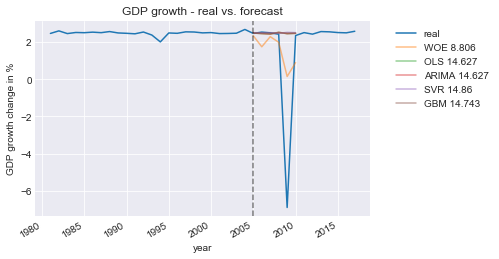

In [77]:
df = database_training[country].append(database_validation[country]).append(database_test[country])

fig, ax = plt.subplots()

ax.plot(df['y'], label='real')

for model in models:
    name = model[0]
    y_forecast = model[1]
    mse = model[2]
    
    label = name + ' ' + str(round(mse,3))
    
    ax.plot(t_forecast_validation,  y_forecast, label=label, alpha=0.5)

ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

ax.set_xlabel('year') 
ax.set_ylabel('GDP growth change in %') 
ax.set_title("GDP growth - real vs. forecast")
legend  = ax.legend(bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()
plt.grid()

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'forecast_out_of_time.png')

#plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
#plt.close()

In [78]:
df_validation_sv

,y,GHG,PPP,ExchangeR,General government net lending/borrowing,Current account balance,"Inflation, average consumer prices"
2005,2.472775,0.613357,0.662556,0.566827,0.306906,1.982254,0.034992
2006,2.544771,0.612713,0.670667,0.523548,0.536216,1.486871,-0.124593
2007,2.506168,0.621832,0.669637,0.532774,0.625513,2.455300,0.692215
2008,2.431226,0.611656,0.662656,0.602292,1.039990,1.725731,-2.734537
2009,-6.907755,0.631547,0.669343,0.600992,0.464254,1.786752,2.847283
2010,2.359842,0.600388,0.666520,0.544789,0.321705,1.823267,0.300099


# Running the models

This is the final evaluation, so models will be trained on the training set combined with the test set and the MSE is calculated with the test set. 

## Training on every country on its own

In [79]:
y_forecast_WEO = {}
y_forecast_ARIMA = {}
y_forecast_OLS = {}
y_forecast_SVR = {}
y_forecast_GBM = {}

df_result_single_countries = pd.DataFrame(columns=['country', 'WEO', 'ARIMA', 'OLS', 'SVR', 'GBM'])

for country in database_training_sv.keys():

    df_training_sv = database_training_sv[country]
    df_validation_sv = database_validation_sv[country]
    
    df_training_sv = pd.concat([df_training_sv, df_validation_sv])
    
    df_test_sv = database_test_sv[country]
    
    t_forecast_test = df_test_sv.index.values
    start_forecast = df_test_sv.index.values[0]

    
    # WEO
    
    y_forecast = get_predictions_weo(df_weo, country = country,
                                     start_forecast =  t_forecast_test[0],
                                     end_forecast = t_forecast_test[-1])
    mse_WEO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_WEO[country] = y_forecast
    
    # ARIMA
    #ValueError: Could not successfully fit ARIMA to input data. 
    #It is likely your data is non-stationary. Please induce stationarity or try a different range of model order params. 
    #If your data is seasonal, check the period (m) of the data.
    
    try:
    
        y_train = df_training_sv.iloc[:, 0]
        X_train = df_training_sv.iloc[:, 1:]
        y_validation = df_test_sv.iloc[:, 0]
        X_validation = df_test_sv.iloc[:, 1:]

        model = auto_arima(y = y_train,
                           trace=True, 
                           start_p=0,
                           max_p=3,
                           start_q=0,
                           max_q=3,
                           seasonal = False,
                           stepwise= True,
                           exogenous=X_train) 

        model.fit(y= y_train, exogenous=X_train)

        y_forecast = model.predict(n_periods=y_validation.shape[0],
                              exogenous = X_validation)
        y_forecast_ARIMA[country] = y_forecast
        mse_ARIMA = mean_squared_error(y_forecast, y_validation)
        
    except Exception as e:
        mse_ARIMA = -1
        y_forecast_ARIMA[country] = [0 for i in range(len(y_forecast))]
        

    
    # OLS
    
    model = LinearRegression()
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_OLS = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_OLS[country] = y_forecast
    
    # SVR
    
    model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
    y_forecast = forecast(model, df_training_sv, df_validation_sv)
    y_forecast = y_forecast.values
    mse_SVR = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_SVR[country] = y_forecast


    
    # GBM
    
    model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                      min_samples_split=10, learning_rate = 0.01)
    y_forecast = forecast(model, df_training_sv, df_test_sv)
    y_forecast = y_forecast.values
    mse_GBM = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_GBM[country] = y_forecast

    
    
    
    df_result_single_countries = pd.concat([pd.DataFrame([[country ,mse_WEO, mse_ARIMA, mse_OLS, mse_SVR, mse_GBM]],
                                                         columns=df_result_single_countries.columns),
                                            df_result_single_countries],ignore_index=True)
    

Fit ARIMA: order=(0, 0, 0); AIC=128.322, BIC=139.531, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 0); AIC=129.159, BIC=141.770, Fit time=0.350 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 1); AIC=123.269, BIC=135.879, Fit time=0.491 seconds
Fit ARIMA: order=(1, 0, 1); AIC=123.060, BIC=137.072, Fit time=1.006 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.

Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1); AIC=123.349, BIC=138.762, Fit time=1.476 seconds
Total fit time: 4.421 seconds
Fit ARIMA: order=(0, 0, 0); AIC=138.278, BIC=149.488, Fit time=0.013 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


Fit ARIMA: order=(1, 0, 0); AIC=137.174, BIC=149.785, Fit time=0.773 seconds
Fit ARIMA: order=(0, 0, 1); AIC=135.161, BIC=147.772, Fit time=0.349 seconds
Fit ARIMA: order=(1, 0, 1); AIC=136.886, BIC=150.898, Fit time=1.105 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=0.213 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.468 seconds
Fit ARIMA: order=(0, 0, 0); AIC=126.535, BIC=137.745, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0); AIC=128.436, BIC=141.047, Fit time=0.359 seconds
Fit ARIMA: order=(0, 0, 1); AIC=128.463, BIC=141.074, Fit time=0.452 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimi

Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.029 seconds
Fit ARIMA: order=(0, 0, 0); AIC=57.468, BIC=68.678, Fit time=0.043 seconds
Fit ARIMA: order=(1, 0, 0); AIC=59.093, BIC=71.704, Fit time=0.431 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=0.327 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.953 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=131.575, BIC=142.785, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0); AIC=133.438, BIC=146.049, Fit time=0.346 seconds
Fit ARIMA: order=(0, 0, 1); AIC=133.408, BIC=146.019, Fit time=0.296 seconds
Fit ARIMA: order=(1, 0, 1); AIC=132.911, BIC=146.923, Fit time=0.539 seconds
Total fit time: 1.203 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-48.998, BIC=-37.788, Fit time=0.021 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-53.516, BIC=-40.905, Fit time=0.610 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 1); AIC=-58.721, BIC=-46.110, Fit time=0.522 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=-56.807, BIC=-42.795, Fit time=1.796 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 0, 2); AIC=-56.786, BIC=-42.774, Fit time=1.121 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 4.085 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=128.585, BIC=139.795, Fit time=0.018 seconds
Fit ARIMA: order=(1, 0, 0); AIC=130.527, BIC=143.138, Fit time=0.308 seconds
Fit ARIMA: order=(0, 0, 1); AIC=130.528, BIC=143.138, Fit time=0.367 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.827 seconds
Fit ARIMA: order=(0, 0, 0); AIC=130.929, BIC=142.138, Fit time=0.018 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 0); AIC=132.537, BIC=145.148, Fit time=0.397 seconds
Fit ARIMA: order=(0, 0, 1); AIC=132.495, BIC=145.106, Fit time=0.310 seconds
Fit ARIMA: order=(1, 0, 1); AIC=131.526, BIC=145.538, Fit time=0.854 seconds
Total fit time: 1.583 seconds
Fit ARIMA: order=(0, 0, 0); AIC=125.967, BIC=137.177, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0); AIC=127.610, BIC=140.221, Fit time=0.370 seconds
Fit ARIMA: order=(0, 0, 1); AIC=127.649, BIC=140.259, Fit time=0.297 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1); AIC=130.339, BIC=144.351, Fit time=0.374 seconds
Total fit time: 1.058 seconds
Fit ARIMA: order=(0, 0, 0); AIC=127.559, BIC=138.769, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0); AIC=129.412, BIC=142.023, Fit time=0.344 seconds
Fit ARIMA: order=(0, 0, 1); AIC=129.415, BIC=142.026, Fit time=0.412 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=131.559, BIC=145.571, Fit time=1.074 seconds
Total fit time: 1.852 seconds
Fit ARIMA: order=(0, 0, 0); AIC=13.783, BIC=24.992, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 0); AIC=14.366, BIC=26.976, Fit time=0.676 seconds
Fit ARIMA: order=(0, 0, 1); AIC=9.531, BIC=22.141, Fit time=0.544 seconds
Fit ARIMA: order=(1, 0, 1); AIC=10.674, BIC=24.686, Fit time=0.709 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 2); AIC=5.442, BIC=19.454, Fit time=1.440 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 3); AIC=7.379, BIC=24.194, Fit time=1.389 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 2); AIC=7.389, BIC=22.803, Fit time=1.524 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 3); AIC=7.360, BIC=22.773, Fit time=1.760 seconds
Total fit time: 8.079 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=-21.684, BIC=-10.475, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-23.467, BIC=-10.857, Fit time=0.494 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-29.927, BIC=-17.317, Fit time=0.506 seconds
Fit ARIMA: order=(1, 0, 1); AIC=-28.023, BIC=-14.011, Fit time=1.133 seconds
Fit ARIMA: order=(0, 0, 2); AIC=-28.061, BIC=-14.049, Fit time=0.931 seconds
Fit ARIMA: order=(1, 0, 2); AIC=-26.130, BIC=-10.717, Fit time=1.827 seconds
Total fit time: 4.924 seconds
Fit ARIMA: order=(0, 0, 0); AIC=63.168, BIC=74.378, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0); AIC=65.098, BIC=77.709, Fit time=0.303 seconds
Fit ARIMA: order=(0, 0, 1); AIC=65.097, BIC=77.708, Fit time=0.327 seconds
Fit ARIMA: order=(1, 0, 1); AIC=67.097, BIC=81.109, Fit time=0.519 seconds
Total fit time: 1.168 seconds
Fit ARIMA: order=(0, 0, 0); AIC=129.526, BIC=140.735, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0); AIC=129.224, BIC=141.835, Fit time=0.305 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=0.201 seconds
Fit ARIMA: order=(2, 0, 0); AIC=121.401, BIC=135.413, Fit time=0.450 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 0); AIC=121.437, BIC=136.850, Fit time=0.776 seconds
Total fit time: 2.439 seconds
Fit ARIMA: order=(0, 0, 0); AIC=124.002, BIC=135.212, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0); AIC=125.937, BIC=138.548, Fit time=0.427 seconds
Fit ARIMA: order=(0, 0, 1); AIC=125.910, BIC=138.521, Fit time=0.374 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anacond

Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.147 seconds
Fit ARIMA: order=(0, 0, 0); AIC=126.353, BIC=137.563, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0); AIC=126.069, BIC=138.680, Fit time=0.565 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Fit ARIMA: order=(0, 0, 1); AIC=123.722, BIC=136.333, Fit time=0.868 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide

Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\bas

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=0.278 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.443 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=70.847, BIC=82.056, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0); AIC=72.694, BIC=85.305, Fit time=0.474 seconds
Fit ARIMA: order=(0, 0, 1); AIC=72.142, BIC=84.753, Fit time=0.443 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=120.498, BIC=134.510, Fit time=0.310 seconds
Total fit time: 1.246 seconds
Fit ARIMA: order=(0, 0, 0); AIC=33.979, BIC=45.189, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0); AIC=30.260, BIC=42.871, Fit time=0.469 seconds
Fit ARIMA: order=(0, 0, 1); AIC=31.110, BIC=43.721, Fit time=0.450 seconds
Fit ARIMA: order=(2, 0, 0); AIC=32.090, BIC=46.102, Fit time=0.721 seconds
Fit ARIMA: order=(1, 0, 1); AIC=32.139, BIC=46.151, Fit time=0.815 seconds
Fit ARIMA: order=(2, 0, 1); AIC=32.556, BIC=47.969, Fit time=1.037 seconds
Total fit time: 3.515 seconds
Fit ARIMA: order=(0, 0, 0); AIC=110.574, BIC=121.784, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 0); AIC=111.812, BIC=124.422, Fit time=0.404 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=0.193 seconds
Fit ARIMA: order=(1, 0, 1); AIC=104.356, BIC=118.367, Fit time=0.869 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(2, 0, 1); AIC=103.915, BIC=119.329, Fit time=1.876 seconds
Fit ARIMA: order=(2, 0, 0); AIC=111.420, BIC=125.432, Fit time=0.723 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(2, 0, 2); AIC=105.976, BIC=122.790, Fit time=1.284 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(3, 0, 2); AIC=107.579, BIC=125.794, Fit time=1.882 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 7.917 seconds
Fit ARIMA: order=(0, 0, 0); AIC=121.749, BIC=132.959, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0); AIC=120.737, BIC=133.348, Fit time=0.364 seconds
Fit ARIMA: order=(0, 0, 1); AIC=115.897, BIC=128.508, Fit time=0.350 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=135.676, BIC=149.688, Fit time=0.263 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 2); AIC=108.128, BIC=122.140, Fit time=1.114 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 3); AIC=129.376, BIC=146.190, Fit time=1.303 seconds
Fit ARIMA: order=(1, 0, 2); AIC=125.020, BIC=140.433, Fit time=1.045 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 3); AIC=108.090, BIC=123.503, Fit time=1.697 seconds
Total fit time: 6.150 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=134.005, BIC=145.214, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0); AIC=135.800, BIC=148.411, Fit time=0.356 seconds
Fit ARIMA: order=(0, 0, 1); AIC=135.781, BIC=148.392, Fit time=0.332 seconds
Fit ARIMA: order=(1, 0, 1); AIC=137.695, BIC=151.706, Fit time=0.614 seconds
Total fit time: 1.322 seconds
Fit ARIMA: order=(0, 0, 0); AIC=89.023, BIC=100.233, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0); AIC=90.985, BIC=103.595, Fit time=0.317 seconds
Fit ARIMA: order=(0, 0, 1); AIC=90.956, BIC=103.567, Fit time=0.323 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=92.695, BIC=106.707, Fit time=0.594 seconds
Total fit time: 1.257 seconds
Fit ARIMA: order=(0, 0, 0); AIC=125.075, BIC=136.284, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0); AIC=126.297, BIC=138.908, Fit time=0.510 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=0.203 seconds
Fit ARIMA: order=(1, 0, 1); AIC=120.503, BIC=134.515, Fit time=0.857 seconds
Fit ARIMA: order=(2, 0, 1); AIC=119.667, BIC=135.080, Fit time=1.197 seconds
Fit ARIMA: order=(2, 0, 0); AIC=123.967, BIC=137.979, Fit time=0.719 seconds
Fit ARIMA: order=(2, 0, 2); AIC=120.945, BIC=137.759, Fit time=2.350 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(3, 0, 2); AIC=122.552, BIC=140.767, Fit time=2.933 seconds
Fit ARIMA: order=(3, 0, 1); AIC=116.676, BIC=133.491, Fit time=2.601 seconds
Fit ARIMA: order=(3, 0, 0); AIC=125.602, BIC=141.015, Fit time=1.182 seconds
Total fit time: 12.573 seconds
Fit ARIMA: order=(0, 0, 0); AIC=38.155, BIC=49.365, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0); AIC=40.126, BIC=52.736, Fit time=0.484 seconds
Fit ARIMA: order=(0, 0, 1); AIC=40.135, BIC=52.746, Fit time=0.380 seconds
Fit ARIMA: order=(1, 0, 1); AIC=40.769, BIC=54.781, Fit time=0.673 seconds
Total fit time: 1.556 seconds
Fit ARIMA: order=(0, 0, 0); AIC=17.013, BIC=28.222, Fit time=0.031 seconds
Fit ARIMA: order=(1, 0, 0); AIC=18.989, BIC=31.600, Fit time=0.311 seconds
Fit ARIMA: order=(0, 0, 1); AIC=19.000, BIC=31.611, Fit time=0.237 seconds
Fit ARIMA: order=(1, 0, 1); AIC=20.424, BIC=34.436, Fit time=0.678 seconds
Total fit time: 1.260 seconds
Fit ARIMA: order=(0, 0, 0); AIC=134.436, BIC=145.646, Fit time=0.017 seconds
F

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 1); AIC=129.567, BIC=142.178, Fit time=0.588 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=131.195, BIC=145.207, Fit time=0.814 seconds
Fit ARIMA: order=(0, 0, 2); AIC=130.993, BIC=145.005, Fit time=0.848 seconds
Fit ARIMA: order=(1, 0, 2); AIC=137.557, BIC=152.970, Fit time=0.782 seconds
Total fit time: 3.535 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=138.413, BIC=149.622, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0); AIC=140.350, BIC=152.960, Fit time=0.380 seconds
Fit ARIMA: order=(0, 0, 1); AIC=140.339, BIC=152.950, Fit time=0.348 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 1); AIC=139.037, BIC=153.049, Fit time=0.605 seconds
Total fit time: 1.350 seconds
Fit ARIMA: order=(0, 0, 0); AIC=136.446, BIC=147.656, Fit time=0.028 seconds
Fit ARIMA: order=(1, 0, 0); AIC=138.337, BIC=150.947, Fit time=0.325 seconds
Fit ARIMA: order=(0, 0, 1); AIC=138.337, BIC=150.948, Fit time=0.237 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.717 seconds
Fit ARIMA: order=(0, 0, 0); AIC=124.768, BIC=135.978, Fit time=0.017 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 0); AIC=126.624, BIC=139.235, Fit time=0.511 seconds
Fit ARIMA: order=(0, 0, 1); AIC=126.671, BIC=139.282, Fit time=0.636 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(1, 0, 1); AIC=130.703, BIC=144.715, Fit time=0.377 seconds
Total fit time: 1.545 seconds
Fit ARIMA: order=(0, 0, 0); AIC=128.002, BIC=139.212, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 0); AIC=129.686, BIC=142.297, Fit time=0.540 seconds
Fit ARIMA: order=(0, 0, 1); AIC=125.781, BIC=138.392, Fit time=0.620 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 0, 2); AIC=127.354, BIC=141.366, Fit time=1.070 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 2); AIC=125.902, BIC=141.315, Fit time=1.728 seconds
Total fit time: 4.117 seconds
Fit ARIMA: order=(0, 0, 0); AIC=119.241, BIC=130.451, Fit time=0.020 seconds
Fit ARIMA: order=(1, 0, 0); AIC=119.134, BIC=131.745, Fit time=0.464 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anacond

Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=0.402 seconds
Fit ARIMA: order=(2, 0, 0); AIC=118.961, BIC=132.973, Fit time=0.909 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(2, 0, 1); AIC=157.683, BIC=173.097, Fit time=0.394 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-package

Fit ARIMA: order=(3, 0, 1); AIC=145.473, BIC=162.287, Fit time=0.818 seconds
Fit ARIMA: order=(3, 0, 0); AIC=118.234, BIC=133.648, Fit time=1.274 seconds
Total fit time: 4.284 seconds
Fit ARIMA: order=(0, 0, 0); AIC=128.975, BIC=140.185, Fit time=0.018 seconds
Fit ARIMA: order=(1, 0, 0); AIC=130.953, BIC=143.563, Fit time=0.628 seconds
Fit ARIMA: order=(0, 0, 1); AIC=130.938, BIC=143.549, Fit time=0.436 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.298 seconds
Fit ARIMA: order=(0, 0, 0); AIC=6.165, BIC=17.375, Fit time=0.018 seconds
Fit ARIMA: order=(1, 0, 0); AIC=7.333, BIC=19.944, Fit time=0.393 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1.050, BIC=13.661, Fit time=0.390 seconds
Fit ARIMA: order=(1, 0, 1); AIC=3.016, BIC=17.028, Fit time=0.533 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\hauer\anaconda3\envs\t

Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=0.343 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.688 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 0); AIC=19.772, BIC=30.982, Fit time=0.035 seconds
Fit ARIMA: order=(1, 0, 0); AIC=18.898, BIC=31.509, Fit time=0.331 seconds
Fit ARIMA: order=(0, 0, 1); AIC=18.659, BIC=31.270, Fit time=0.443 seconds
Fit ARIMA: order=(1, 0, 1); AIC=17.412, BIC=31.424, Fit time=0.747 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 2); AIC=17.626, BIC=33.039, Fit time=0.952 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(2, 0, 2); AIC=19.619, BIC=36.434, Fit time=1.314 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:670: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 4.104 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (i

Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=128.224, BIC=139.433, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0); AIC=130.159, BIC=142.770, Fit time=0.231 seconds
Fit ARIMA: order=(0, 0, 1); AIC=130.146, BIC=142.756, Fit time=0.375 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.722 seconds
Fit ARIMA: order=(0, 0, 0); AIC=31.012, BIC=42.221, Fit time=0.017 se

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(1, 0, 0); AIC=32.738, BIC=45.349, Fit time=0.296 seconds
Fit ARIMA: order=(0, 0, 1); AIC=25.794, BIC=38.404, Fit time=0.513 seconds
Fit ARIMA: order=(1, 0, 1); AIC=27.637, BIC=41.649, Fit time=1.354 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(0, 0, 2); AIC=21.592, BIC=35.604, Fit time=0.550 seconds
Fit ARIMA: order=(1, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(1, 0, 2); AIC=23.013, BIC=38.426, Fit time=0.866 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 3); AIC=15.539, BIC=30.952, Fit time=0.967 seconds
Total fit time: 4.580 seconds


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Fit ARIMA: order=(0, 0, 0); AIC=142.775, BIC=153.985, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0); AIC=144.443, BIC=157.054, Fit time=0.664 seconds
Fit ARIMA: order=(0, 0, 1); AIC=144.369, BIC=156.979, Fit time=0.523 seconds
Fit ARIMA: order=(1, 0, 1); AIC=146.242, BIC=160.254, Fit time=0.665 seconds
Total fit time: 1.876 seconds
Fit ARIMA: order=(0, 0, 0); AIC=126.304, BIC=137.513, Fit time=0.015 seconds


KeyboardInterrupt: 

Creating Plots

In [ ]:
for country in database_training_sv.keys():

    df = database_training_sv[country].append(database_validation_sv[country]).append(database_test_sv[country])

    fig, ax = plt.subplots()

    ax.plot(df['y'], label='real')

    row = df_result_single_countries[df_result_single_countries['country'] == country]
    for model in ['WEO', 'ARIMA', 'OLS', 'GBM']:
        name = model

        if model == 'WEO':
            y_forecast = y_forecast_WEO[country]
        elif model == 'ARIMA':
            y_forecast = y_forecast_ARIMA[country]
        elif model == 'SVR':
            y_forecast = y_forecast_SVR[country]
        elif model == 'OLS':
            y_forecast = y_forecast_OLS[country]
        elif model == 'GBM':
            y_forecast = y_forecast_GBM[country]

        mse = row[model].values[0]

        label = name + ' ' + str(round(mse,3))

        ax.plot(t_forecast_test,  y_forecast, label=label, alpha=0.5)

    ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

    ax.set_xlabel('year') 
    ax.set_ylabel('GDP growth change in %') 
    ax.set_title("GDP growth - real vs. forecast - " + country)
    legend  = ax.legend(bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()
    plt.grid()

    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_single_countries'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.close()

Result

In [ ]:
df_result_single_countries

## Training the whole data set

In [ ]:
df_training_sv_complete = pd.DataFrame()
for country in database_training_sv.keys():
    df_training_sv = database_training_sv[country]
    df_validation_sv = database_validation_sv[country]
    
    df_training_sv = pd.concat([df_training_sv, df_validation_sv])

    df_training_sv_complete = pd.concat([df_training_sv_complete, df_training_sv]) 

Defining RNN

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)

In [ ]:
y_forecast_WEO = {}
y_forecast_OLS = {}
y_forecast_SVR = {}
y_forecast_GBM = {}
y_forecast_RNN = {}

df_result_all_countries = pd.DataFrame(columns=['country', 'WEO', 'OLS', 'SVR', 'GBM', 'RNN'])
N, dummy_dim = database_training_sv_standard['Germany'].shape
dummy_dim -= 1


for country in database_training_sv.keys():
#for country in ['Germany', 'France']:

    
    df_test_sv = database_test_sv[country]
    
    t_forecast_test = df_test_sv.index.values
    start_forecast = df_test_sv.index.values[0]

    
    # WEO
    
    y_forecast = get_predictions_weo(df_weo, country = country,
                                     start_forecast =  t_forecast_test[0],
                                     end_forecast = t_forecast_test[-1])
    mse_WEO = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_WEO[country] = y_forecast
    
     

    
    # OLS
    
    model = LinearRegression()
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_OLS = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_OLS[country] = y_forecast
    
    # SVR
    
    model = SVR(C=0.1, epsilon=0.05, kernel = 'sigmoid')
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_SVR = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_SVR[country] = y_forecast

    
    # GBM
    
    name = 'GBM'
    model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                      min_samples_split=10, learning_rate = 0.01)
    y_forecast = forecast(model, df_training_sv_complete, df_test_sv)
    y_forecast = y_forecast.values
    mse_GBM = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_GBM[country] = y_forecast
    
    
    # RNN
    
    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
    save_dir = os.path.join(wdir, 'pytorch_models')
    model_name = 'rnn.torch'
    
    hidden_dim = 64
    model = LSTMNet(input_size=6, seq_len=17, output_size=1, hidden_dim=hidden_dim, n_layers=1)
    model.load_state_dict(load( os.path.join(save_dir, model_name)))
    
    
    df = database_training_sv_standard[country].append(database_validation_sv_standard[country]).append(database_test_sv_standard[country])

    n_forecast_validation, _ = database_test_sv_standard[country].shape

    X_eval = df.iloc[:,1:].values
    y_eval = df.iloc[:,0].values
    X_eval_T = from_numpy(X_eval).float()
    N, _ = X_eval_T.shape
    X_eval_T = X_eval_T.view([-1, N, dummy_dim])

    hidden_1 = zeros(1, N, hidden_dim)
    state_1 = zeros(1, N, hidden_dim)

    hidden_2 = zeros(1, N, hidden_dim)
    state_2 = zeros(1, N, hidden_dim)

    model.eval()
    with no_grad():
        y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)

    y_hat =  y_hat.view(-1).numpy()
    y_forecast = y_hat[-n_forecast_validation:]
    
    # Inverse tranformation 
    
    scaler = database_scaler[country]
    df_output = database_test_sv_standard[country]
    df_output.iloc[:,0] = y_forecast
    df_output = pd.DataFrame(scaler.inverse_transform(df_output))
    y_forecast = df_output.iloc[:,0].values
    
    
    mse_RNN = mean_squared_error(y_forecast, df_test_sv['y'].values)
    y_forecast_RNN[country] = y_forecast
    

    
    
    
    df_result_all_countries = pd.concat([pd.DataFrame([[country ,mse_WEO,mse_OLS, mse_SVR, mse_GBM, mse_RNN]],
                                                         columns=df_result_all_countries.columns),
                                            df_result_all_countries],ignore_index=True)
    

Creating plots

In [ ]:
for country in database_training_sv.keys():

    df = database_training_sv[country].append(database_validation_sv[country]).append(database_test_sv[country])

    fig, ax = plt.subplots()

    ax.plot(df['y'], label='real')

    row = df_result_all_countries[df_result_all_countries['country'] == country]
    for model in ['WEO', 'OLS', 'GBM', 'RNN']:
        name = model

        if model == 'WEO':
            y_forecast = y_forecast_WEO[country]
        elif model == 'RNN':
            y_forecast = y_forecast_RNN[country]
        elif model == 'OLS':
            y_forecast = y_forecast_OLS[country]
        elif model == 'SVR':
            y_forecast = y_forecast_SVR[country]
        elif model == 'GBM':
            y_forecast = y_forecast_GBM[country]

        mse = row[model].values[0]

        label = name + ' ' + str(round(mse,3))

        ax.plot(t_forecast_test,  y_forecast, label=label, alpha=0.5)

    ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

    ax.set_xlabel('year') 
    ax.set_ylabel('GDP growth change in %') 
    ax.set_title("GDP growth - real vs. forecast - " + country)
    legend  = ax.legend(bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()
    plt.grid()

    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_all_countries'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.close()

Result

In [ ]:
df_result_all_countries

In [ ]:
df_result = df_result_all_countries
N, _ = df_result.shape

classic_models = ['WEO', 'OLS']
machine_learning_models = [x for x in df_result_all_countries.keys() if x not in ['country', 'WEO', 'OLS', 'ARIMA']]

df_result_all_countries_aggregated = pd.DataFrame(columns=machine_learning_models)


for classic_model in classic_models:   
    
    SVR = sum(df_result_all_countries[classic_model] > df_result_all_countries['SVR']) / N
    GBM = sum(df_result_all_countries[classic_model] > df_result_all_countries['GBM']) / N
    RNN = sum(df_result_all_countries[classic_model] > df_result_all_countries['RNN']) / N
    
    df_result_all_countries_aggregated = pd.concat([pd.DataFrame([[SVR, GBM ,RNN]],
                                                         columns=df_result_all_countries_aggregated.columns),
                                            df_result_all_countries_aggregated],ignore_index=True)
    
df_result_all_countries_aggregated.index = classic_models

df_result_all_countries_aggregated

## Evaluation of the Deep Reinforcement Learning framework

Runnig the model: 

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=32)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1
        
    def get_q_valid(self, q, valid_actions):
        q_valid = [np.nan] * len(q)
        for action in valid_actions:
            q_valid[action] = q[action]
        
        return q_valid

    def choose_action(self, observation, valid_actions):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float32).to(self.Q_eval.device)
            q = self.Q_eval.forward(state)
            q = q.detach().numpy().squeeze()
            q = self.get_q_valid(q, valid_actions)
            action = np.nanargmax(q)
        else:
            action = np.random.choice(valid_actions)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

def get_prediction(action, empty_status):
    # Determines prediction on a given empty_status and action
    # if empty, i. e. no stock is in depot, if action == 1 (buying) you bet on rising price
    # if not empty, i. e. stock is in depot, if action == 0 (selling) you bet on falling price
    
    if empty_status:
        if action == 1:
            return 1
        return -1
    else:
        if action == 0:
            return -1
        return 1

class Environment():
    
    
    def __init__(self, n_epochs, window_size_observation, size_time_series, database):
        self.name = 'gao'
        self.n_epochs = n_epochs
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        self.database = database
        
        self.list_of_games = self.get_list_of_games()
        self.n_games = len(self.list_of_games)
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_epochs):
            for country in self.database.keys():
                list_of_games.append(self.database[country])
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 

        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep 
        
    def set_list_of_games(self, df):
        self.list_of_games = [df]
        self.n_games = 1
  
        
    def render(self):
        pass

Prepare final training database, i. e. the database that consits of the original training and validation set:

In [ ]:
database_training_RL = {}

for country in database_training_sv_standard.keys():
    df_to_add = database_training_sv_standard[country].append(database_validation_sv_standard[country])
    df_to_add = df_to_add.reset_index()
    del df_to_add['index']

    database_training_RL[country] = df_to_add

In [ ]:
N, p = database_training_sv_standard['Germany'].shape


n_epochs = 1
window_size_observation = 15
size_time_series = N


agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
              input_dims=[window_size_observation * p], lr=0.001, eps_dec=2e-5)

env = Environment(n_epochs, window_size_observation, size_time_series, database_training_RL)
n_games = env.n_games

n_countries = len(database_training_sv_standard.keys())

scores, eps_history = [], []

for i in range(n_games):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    #observation = observation.iloc[:, 1:].values.squeeze()
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        #observation_ = observation_.iloc[:, 1:].values.squeeze()
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_

    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    
    if i % n_countries == 0:
        print('episode ', i / n_countries, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

In [ ]:
y_forecast_GAO = {}


for country in database_training_sv_standard.keys():

    df_to_predict = database_training_sv_standard[country].append(database_validation_sv_standard[country]).append(database_test_sv_standard[country])
    df_to_predict = df_to_predict.reset_index()
    del df_to_predict['index']
    n_forecast_validation = 6

    N, p = df_to_predict.shape
    size_time_series = N

    env = Environment(n_epochs, window_size_observation, size_time_series, database_training_sv_standard)

    env.set_list_of_games(df_to_predict)



    agent.epsilon = 0

    actions, empty_status, rewards = [], [], []

    for i in range(1):
        score = 0
        done = False

        observation = env.reset()
        valid_actions = [0, 1]

        # take only signal as observation for now: 
        observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)


            # take only signal as observation for now: 
            observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

            score += reward
            observation = observation_


            empty_status.append(env.get_status_emtpy())
            actions.append(action)
            rewards.append(reward)



        df = env.get_current_df()
        predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]

        predictions = [0 for i in range(window_size_observation)] + predictions
        rewards = [0 for i in range(window_size_observation)] + rewards
        actions = [0 for i in range(window_size_observation)] + actions


    y_forecast = predictions[-n_forecast_validation:]
    y_forecast_GAO[country] = y_forecast


    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)


    ax.plot(df.iloc[:,0], label='price')
    ax.axvline(x= len(df) - n_forecast_validation - 1, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
    ax.grid()
    ax.set_ylabel('price') 
    ax.set_title("Price and predictions")



    ax2.plot(predictions, 'ro-')
    ax2.set_xlabel('t') 
    ax2.set_ylabel('predictions') 



    plt.grid()



    wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project/plots_drl_gao'
    save_dir = os.path.join(wdir, country+'.png')

    plt.savefig(save_dir, dpi = 500, bbox_inches='tight')
    plt.close()


Mapping the prediction from the models, that where trained with the complete data:

In [ ]:
y_forecast_WEO_RL = {}
y_forecast_OLS_RL = {}
y_forecast_GBM_RL = {}
y_forecast_RNN_RL = {}


for country in y_forecast_WEO.keys():
    y_forecast_WEO_RL[country] = np.where(y_forecast_WEO[country].values > 0, 1, -1)
    y_forecast_OLS_RL[country]  = np.where(y_forecast_OLS[country] > 0, 1, -1)
    y_forecast_GBM_RL[country]  = np.where(y_forecast_GBM[country] > 0, 1, -1)
    y_forecast_RNN_RL[country]  = np.where(y_forecast_RNN[country] > 0, 1, -1)


In [ ]:
df_result_RL = pd.DataFrame(columns=['country', 'WEO', 'OLS', 'GBM', 'RNN', 'GAO'])

for country in y_forecast_OLS_RL.keys():
    
    df_test_sv = database_test_sv[country]
    y_real = df_test_sv['y'].values
    y_real = np.where(y_real > 0, 1, -1)
   
   
    mse_WEO = sum(y_real == y_forecast_WEO_RL[country]) / 6
    mse_OLS = sum(y_real == y_forecast_OLS_RL[country]) / 6
    mse_GBM = sum(y_real == y_forecast_GBM_RL[country]) / 6
    mse_RNN = sum(y_real == y_forecast_RNN_RL[country]) / 6
    mse_GAO = sum(y_real == y_forecast_GAO[country]) / 6


    df_result_RL = pd.concat([pd.DataFrame([[country ,mse_WEO,mse_OLS,mse_GBM, mse_RNN, mse_GAO]],
                                                          columns=df_result_RL.columns),
                                             df_result_RL],ignore_index=True)

In [ ]:
df_result_RL